In [1]:
!nvidia-smi

Wed Jan  4 04:22:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ln -s /content/drive/MyDrive/Course/NLP/code/* ./

In [3]:
!git init

Reinitialized existing Git repository in /content/.git/


# 下载并 import 库

In [5]:
# install requirments
!pip install -r ./requirements.txt
!pip install --upgrade jupyter ipywidgets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 50.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 20.4 MB/s eta 0:00:00
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=444fee3fda3875a2a640ed625090dcbcf8a8962ada9229bc326dc79be75d5af9
  Stored in dire

In [6]:
# install fairseq
!git submodule add https://github.com/pytorch/fairseq.git
!git submodule init
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

Cloning into '/content/fairseq'...
remote: Enumerating objects: 34294, done.
remote: Total 34294 (delta 0), reused 0 (delta 0), pack-reused 34294
Receiving objects: 100% (34294/34294), 23.78 MiB | 14.86 MiB/s, done.
Resolving deltas: 100% (24980/24980), done.
Note: checking out '9a1c497'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies

In [1]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# 数据集下载和前处理

In [ ]:
# 下载数据集 https://drive.google.com/open?id=1EX8eE5YWBxCaohBO8Fh4e2j3b9C2bTVQ 并放到 data/translation2019zh_520000 目录下
!cd data/translation2019zh_520000 && unzip translation2019zh.zip

Archive:  translation2019zh.zip
  inflating: translation2019zh_train.json  
  inflating: translation2019zh_valid.json  


In [ ]:
data_dir = './data/'
dataset_name = 'translation2019zh_520000'
prefix = Path(data_dir).absolute() / dataset_name
prefix.mkdir(parents=True, exist_ok=True)
train_size = 520000
test_size = 1000

In [ ]:
# 处理数据集
import json
with open(f'{prefix}/translation2019zh_train.json','r',encoding='utf8') as f:
  with open(f'{prefix}/train_dev.raw.zh','w',encoding='utf8') as zhf:
    with open(f'{prefix}/train_dev.raw.en','w',encoding='utf8') as enf:
      with open(f'{prefix}/test.raw.zh','w',encoding='utf8') as zhtf:
        with open(f'{prefix}/test.raw.en','w',encoding='utf8') as entf:
          for i in range(520000):
            json_data = json.loads(f.readline())
            zhf.write(json_data['chinese']+'\n')
            enf.write(json_data['english']+'\n')
          for i in range(1000):
            json_data = json.loads(f.readline())
            zhtf.write('。\n')
            entf.write(json_data['english']+'\n')
        

In [ ]:
# 设定语言
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [ ]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

For greater sharpness, but with a slight increase in graininess, you can use a 1:1 dilution of this developer.
He calls the Green Book, his book of teachings, “the new gospel.
And the light breeze moves me to caress her long ear
They have the blood of martyrs is the White to flow …
Finally, the Lakers head to the Motor City to take on a Pistons team that currently owns the Eastern Conference's second best record (1/31). L.
为了更好的锐度，但是附带的会多一些颗粒度，可以使用这个显影剂的1：1稀释液。
他还把宣扬自己思想的所谓《绿皮书》称作“新福音书”。
微风推着我去爱抚它的长耳朵
它们的先烈们的鲜血是白流了…
最后，在1月31日，湖人将前往汽车城底特律挑战活塞队，活塞近来在东部排名第二。


In [ ]:
# 数据前处理
import re

def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全角空格直接转换
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [ ]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [ ]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

For greater sharpness , but with a slight increase in graininess , you can use a 1:1 dilution of this developer .
He calls the Green Book , his book of teachings , “the new gospel .
And the light breeze moves me to caress her long ear
They have the blood of martyrs is the White to flow …
Finally , the Lakers head to the Motor City to take on a Pistons team that currently owns the Eastern Conference's second best record . L .
为了更好的锐度 , 但是附带的会多一些颗粒度 , 可以使用这个显影剂的1:1稀释液 。
他还把宣扬自己思想的所谓《绿皮书》称作 " 新福音书 " 。
微风推着我去爱抚它的长耳朵
它们的先烈们的鲜血是白流了…
最后 , 在1月31日 , 湖人将前往汽车城底特律挑战活塞队 , 活塞近来在东部排名第二 。


# 切分 train/valid set

In [ ]:
valid_ratio = 0.01 # 1% of data
train_ratio = 1 - valid_ratio

In [ ]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

# 分词

In [ ]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='bpe', # or 'unigram'
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /home/stceum/simple_NMT_on_transformer/code/data/translation2019zh_520000/train.clean.en
  input: /home/stceum/simple_NMT_on_transformer/code/data/translation2019zh_520000/valid.clean.en
  input: /home/stceum/simple_NMT_on_transformer/code/data/translation2019zh_520000/train.clean.zh
  input: /home/stceum/simple_NMT_on_transformer/code/data/translation2019zh_520000/valid.clean.zh
  input_format: 
  model_prefix: /home/stceum/simple_NMT_on_transformer/code/data/translation2019zh_520000/spm8000
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 1000000
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whites

In [ ]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

In [ ]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁for ▁g re ater ▁sh ar p ness ▁, ▁but ▁with ▁a ▁s l ight ▁in cre ase ▁in ▁gra in iness ▁, ▁you ▁can ▁use ▁a ▁1 : 1 ▁d il ution ▁of ▁this ▁develop er ▁.
▁he ▁call s ▁the ▁g re en ▁bo ok ▁, ▁his ▁bo ok ▁of ▁te ach ings ▁, ▁ “ t he ▁new ▁g os p el ▁.
▁and ▁the ▁l ight ▁b ree z e ▁mo v es ▁me ▁to ▁c a ress ▁her ▁long ▁ear
▁they ▁have ▁the ▁bl ood ▁of ▁m art y r s ▁is ▁the ▁wh ite ▁to ▁fl ow ▁. ..
▁fin ally ▁, ▁the ▁l ak ers ▁he ad ▁to ▁the ▁m ot or ▁c ity ▁to ▁t ake ▁on ▁a ▁p ist ons ▁te am ▁that ▁cur re nt ly ▁o wn s ▁the ▁e as ter n ▁con f ere n ce ' s ▁se con d ▁b est ▁rec ord ▁. ▁l ▁.
▁为 了 更 好 的 锐 度 ▁, ▁但是 附 带 的 会 多 一些 颗 粒 度 ▁, ▁ 可以 使用 这个 显 影 剂 的 1 : 1 稀 释 液 ▁。
▁他 还 把 宣 扬 自己 思 想 的 所 谓 《 绿 皮 书 》 称 作 ▁" ▁ 新 福 音 书 ▁" ▁。
▁ 微 风 推 着 我 去 爱 抚 它 的 长 耳 朵
▁它 们 的 先 烈 们 的 鲜 血 是 白 流 了 .. .
▁ 最 后 ▁, ▁在 1 月 3 1 日 ▁, ▁ 湖 人 将 前 往 汽 车 城 底 特 律 挑 战 活 塞 队 ▁, ▁ 活 塞 近 来 在 东 部 排 名 第 二 ▁。


# 使用 fairseq 将数据转化为 binary

In [ ]:
binpath = Path('./data/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

2023-01-03 13:54:46 | INFO | fairseq_cli.preprocess | Namespace(no_progress_bar=False, log_interval=100, log_format=None, tensorboard_logdir=None, wandb_project=None, azureml_logging=False, seed=1, cpu=False, tpu=False, bf16=False, memory_efficient_bf16=False, fp16=False, memory_efficient_fp16=False, fp16_no_flatten_grads=False, fp16_init_scale=128, fp16_scale_window=None, fp16_scale_tolerance=0.0, min_loss_scale=0.0001, threshold_loss_scale=None, user_dir=None, empty_cache_freq=0, all_gather_list_size=16384, model_parallel_size=1, quantization_config_path=None, profile=False, reset_logging=False, suppress_crashes=False, criterion='cross_entropy', tokenizer=None, bpe=None, optimizer=None, lr_scheduler='fixed', scoring='bleu', task='translation', source_lang='en', target_lang='zh', trainpref='/home/stceum/simple_NMT_on_transformer/code/data/translation2019zh_520000/train', validpref='/home/stceum/simple_NMT_on_transformer/code/data/translation2019zh_520000/valid', testpref='/home/stceum

# 设定实验参数

In [2]:
config = Namespace(
    datadir = "./data/data-bin/translation2019zh_520000",
    savedir = "./checkpoints/transformer",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    # max_tokens=8192,
    max_tokens=16384,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=True,
)

# 记录日志

In [8]:
logging.basicConfig(
    filename='run.log',
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    # level="INFO", # "DEBUG" "WARNING" "ERROR"
    level=logging.INFO,
    stream=sys.stdout,
)
proj = "simple_NMT_on_transformer"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: stceum. Use `wandb login --relogin` to force relogin


In [9]:
logger.setLevel(logging.INFO)
logging.info("testing logging.info")

INFO:root:testing logging.info


# CUDA 环境

In [10]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

INFO:fairseq.utils:***********************CUDA enviroments for all 1 workers***********************
INFO:fairseq.utils:rank   0: capabilities =  7.5  ; total memory = 14.756 GB ; name = Tesla T4                                
INFO:fairseq.utils:***********************CUDA enviroments for all 1 workers***********************


# 读取数据集

In [11]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

INFO:fairseq.tasks.translation:[en] dictionary: 8040 types
INFO:fairseq.tasks.translation:[zh] dictionary: 8040 types


In [12]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

INFO:simple_NMT_on_transformer:loading data for epoch 1
INFO:fairseq.data.data_utils:loaded 513,843 examples from: ./data/data-bin/translation2019zh_520000/train.en-zh.en
INFO:fairseq.data.data_utils:loaded 513,843 examples from: ./data/data-bin/translation2019zh_520000/train.en-zh.zh
INFO:fairseq.tasks.translation:./data/data-bin/translation2019zh_520000 train en-zh 513843 examples
INFO:fairseq.data.data_utils:loaded 5,190 examples from: ./data/data-bin/translation2019zh_520000/valid.en-zh.en
INFO:fairseq.data.data_utils:loaded 5,190 examples from: ./data/data-bin/translation2019zh_520000/valid.en-zh.zh
INFO:fairseq.tasks.translation:./data/data-bin/translation2019zh_520000 valid en-zh 5190 examples


In [13]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  13,  129,  458,   15,  587,   91,   71,    7,  828,  282,    4,  776,
        1040,  126,  644,   12,    7,   66,  127,   39,   20,  455,   54,   64,
         274,   40,   20,   13,   19,   54,  301,   18,    5,   83,  202,   95,
          17,   84,  388,  372,    7,  305,  713,   99,  265,  478,    5,  153,
          17,   94,   21,  913,   14,   66,  127,   39,   20,  187,  572,   12,
         472,   19,  391,   22,   66,  127,   39,   20,  828,  282,    9,    2]),
 'target': tensor([   4,  654, 1452, 1418,  774,  210,  321,  314,  629,  192,  238,  221,
        1418,  774,  321,  666,  349,    8, 1285,  513,  710,    5,    4,  839,
         213,  661,  917, 1418,  774,  210,  321,  197,  291,  730,   68,  198,
         527,  253,    5,    4, 1750,  568,  836,  361, 1418,  774,  270,  352,
         447,  857,  834,  614,  226,  386,  105,   10,    2])}
('Source: in order to improve the production efficiency of the clothing '
 'manufacturing industry , i

In [14]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

{'id': tensor([4384]),
 'nsentences': 1,
 'ntokens': 16,
 'net_input': {'src_tokens': tensor([[   1,    1,    1,    1,    1,    1,    1,    7, 1356,   30,   11,  866,
           1381,   23,   13,   76,   31,   88,   82,  207,  842,    6,    9,    2]]),
  'src_lengths': tensor([17]),
  'prev_output_tokens': tensor([[   2,  320,  262,  583,    8,  247,  461, 1220,   36,  356, 1001, 1103,
           2784,   42,  663,   10]])},
 'target': tensor([[ 320,  262,  583,    8,  247,  461, 1220,   36,  356, 1001, 1103, 2784,
            42,  663,   10,    2]])}

# 定义 Seq2Seq

In [15]:
from fairseq.models import FairseqEncoderDecoderModel
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# 模型初始化

In [16]:
# transformer 构架
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ 按照参数设置并建立模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 词嵌入
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 编码器与解码器
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別处理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # 初始化模型
    model.apply(init_params)
    return model

# 设定模型参数

In [17]:
arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=1024,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# Transformer 要用的参数
def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 补上没有设定的 Transformer 预设参数
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [18]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [19]:
model = build_model(arch_args, task)
logger.info(model)

INFO:simple_NMT_on_transformer:Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8040, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=256, bias=True)
    

# Optimization

In [20]:
# Loss: Label Smoothing Regularization

class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，当目标是one-hot时的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 将一部分正确答案的机率分配给其它label 所以当计算 cross-entropy 时等于把所有 label 的 log prob 加起来
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 计算 cross-entropy 时 加入分配给其他 label 的 loss
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

In [21]:
# optimizer: Adam + lr scheduling
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

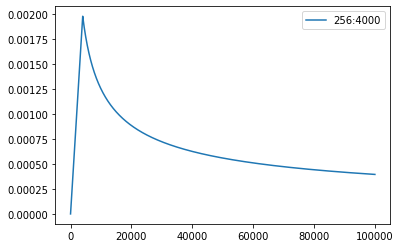

In [22]:
# 可视化 lr 变化
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training

In [23]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度积累: 每 accum_steps 个 sample 更新一次
    
    stats = {"loss": []}
    scaler = GradScaler() # 混合精度训练 automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累积: 每 accum_steps 个 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # 混合精度训练 
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪 防止梯度爆炸
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

# validation and inference

In [24]:
# fairseq 的 beam search generator
# 给定模型和输入序列，用 beam search 生成翻译结果
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 从 Tensor 转成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 对于每个 sample, 收集输入，输出和参考答案，稍后计算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 内分数第一的输出结果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [25]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # 进行推论
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 计算 BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save model and Load model

In [26]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# 主程序

In [27]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [28]:
!nvidia-smi

Wed Jan  4 04:28:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    27W /  70W |    620MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [29]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

INFO:simple_NMT_on_transformer:task: TranslationTask
INFO:simple_NMT_on_transformer:encoder: TransformerEncoder
INFO:simple_NMT_on_transformer:decoder: TransformerDecoder
INFO:simple_NMT_on_transformer:criterion: LabelSmoothedCrossEntropyCriterion
INFO:simple_NMT_on_transformer:optimizer: NoamOpt
INFO:simple_NMT_on_transformer:num. model params: 11,490,304 (num. trained: 11,490,304)
INFO:simple_NMT_on_transformer:max tokens per batch = 16384, accumulate steps = 2


In [30]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

INFO:simple_NMT_on_transformer:no checkpoints found at checkpoints/transformer/checkpoint_last.pt!


train epoch 1:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 6.8841
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: as a result , the thick of branches has great effect on youg trees . it has direct relation with its survival rate , growing conditions as well as commercial rate of young fig trees .
INFO:simple_NMT_on_transformer:example hypothesis: 然后 , 然后 , 然后 , 可可可用用用用用用用户 , 还有效效效效的影响 。
INFO:simple_NMT_on_transformer:example reference: 试验结果表明 , 插穗粗度对无花果扦插育苗的成活率、生长状况及商品苗率均有影响 。
INFO:simple_NMT_on_transformer:validation loss:	5.6925
INFO:simple_NMT_on_transformer:BLEU = 0.56 11.8/1.0/0.2/0.1 (BP = 0.855 ratio = 0.864 hyp_len = 151249 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint1.pt
INFO:simple_NMT_on_transformer:end of epoch 1


train epoch 2:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 5.3804
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: these landforms were dubbed tiankeng , or " naturally formed pits " .
INFO:simple_NMT_on_transformer:example hypothesis: 这些文化是 " 的 " 或 " 或 " 是 " 或 " 的 " 。
INFO:simple_NMT_on_transformer:example reference: 这些地貌现象被称作天坑 , 或者 " 自然形成的坑洞 " 。
INFO:simple_NMT_on_transformer:validation loss:	4.9836
INFO:simple_NMT_on_transformer:BLEU = 3.38 23.8/6.0/1.9/0.6 (BP = 0.962 ratio = 0.963 hyp_len = 168471 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint2.pt
INFO:simple_NMT_on_transformer:end of epoch 2


train epoch 3:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 4.9277
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: i have a stomachache . i think i got some bad food at lunch today .
INFO:simple_NMT_on_transformer:example hypothesis: 我有一个故事 。 我认为我在今天的食物 。
INFO:simple_NMT_on_transformer:example reference: 我肚子痛得厉害 ! 我想中午一定是吃了不干净的东西了 。
INFO:simple_NMT_on_transformer:validation loss:	4.6064
INFO:simple_NMT_on_transformer:BLEU = 5.92 34.2/11.4/4.5/1.8 (BP = 0.795 ratio = 0.813 hyp_len = 142263 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint3.pt
INFO:simple_NMT_on_transformer:end of epoch 3


train epoch 4:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 4.6128
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: this could mean different things for different members of the spy ring , says mikhail lyubimov , a retired colonel of the kgb and a renowned cold war spy .
INFO:simple_NMT_on_transformer:example hypothesis: 这可能意味着不同的环境的不同的东西 , 迈克·哈哈哈说 , 一个反映了kgb和一个红色的冷暖空间 。
INFO:simple_NMT_on_transformer:example reference: 哈伊尔留比莫夫 , 一位退休的克格勃上校 , 冷战时期有名的间谍 , 说 , 在特工圈里 , 对不同的人来说 , 这些话有不用的意义 。
INFO:simple_NMT_on_transformer:validation loss:	4.2770
INFO:simple_NMT_on_transformer:BLEU = 10.07 36.9/14.7/6.6/3.0 (BP = 0.985 ratio = 0.985 hyp_len = 172360 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint4.pt
INFO:simple_NMT_on_transformer:end of epoch 4


train epoch 5:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 4.3600
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: it is believed that on december 21st , 1891 , the first basketball game in history was played .
INFO:simple_NMT_on_transformer:example hypothesis: 18911年12月21日 , 1891年12月21日 , 第一次篮球游戏在历史上扮演了 。
INFO:simple_NMT_on_transformer:example reference: 一般相信 , 在1891年十二月21日 , 在历史的第一场篮球游戏被打 。
INFO:simple_NMT_on_transformer:validation loss:	4.0887
INFO:simple_NMT_on_transformer:BLEU = 12.57 40.0/17.6/8.4/4.2 (BP = 1.000 ratio = 1.039 hyp_len = 181734 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint5.pt
INFO:simple_NMT_on_transformer:end of epoch 5


train epoch 6:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 4.1989
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: they also found almost no difference between methods in male and female workers , suggesting that careerdriven women were just as “competitive” during salary negotiations .
INFO:simple_NMT_on_transformer:example hypothesis: 他们也发现了男性和女性工作者之间的差异 , 提示 , 职业驱动性女性只是 " 竞争性 " 。
INFO:simple_NMT_on_transformer:example reference: 研究还发现 , 男性和女性员工在要求加薪的时候使用的方法基本相同 , 这说明了事业型女性在谈工资的时候和男性一样 " 强势 " 。
INFO:simple_NMT_on_transformer:validation loss:	3.9402
INFO:simple_NMT_on_transformer:BLEU = 13.54 51.4/23.8/11.9/6.2 (BP = 0.780 ratio = 0.801 hyp_len = 140119 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint6.pt
INFO:simple_NMT_on_transformer:end of epoch 6


train epoch 7:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 4.0671
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: for whatever reason , i tend to think of him as a lowprofile “insider , ” but his publication history belies this image .
INFO:simple_NMT_on_transformer:example hypothesis: 无论如此 , 我倾向认为他是一个低级的 " 中文 " 的低级 " , 但他的出版历史相信这幅图像 。
INFO:simple_NMT_on_transformer:example reference: 不管是什么原因 , 我认为他曾经的出版物 , 掩饰了他这个低调的权威人士 。
INFO:simple_NMT_on_transformer:validation loss:	3.8473
INFO:simple_NMT_on_transformer:BLEU = 15.81 50.2/23.8/12.1/6.5 (BP = 0.905 ratio = 0.909 hyp_len = 159099 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint7.pt
INFO:simple_NMT_on_transformer:end of epoch 7


train epoch 8:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.9738
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: this can be made a skip test to try to ping localhost if apache is in the process list .
INFO:simple_NMT_on_transformer:example hypothesis: 这可以做一个skip测试来尝试试在过程列表中执行局部主机 。
INFO:simple_NMT_on_transformer:example reference: 如果apache在进程列表中 , 则可以进行skip测试以尝试ping本地主机 。
INFO:simple_NMT_on_transformer:validation loss:	3.7764
INFO:simple_NMT_on_transformer:BLEU = 15.81 53.7/25.8/13.4/7.4 (BP = 0.822 ratio = 0.836 hyp_len = 146341 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint8.pt
INFO:simple_NMT_on_transformer:end of epoch 8


train epoch 9:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.9095
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: sit cross legged on the floor .
INFO:simple_NMT_on_transformer:example hypothesis: 坐在地板上 。
INFO:simple_NMT_on_transformer:example reference: 两腿交叉坐在地板上 。
INFO:simple_NMT_on_transformer:validation loss:	3.7194
INFO:simple_NMT_on_transformer:BLEU = 17.14 52.0/25.4/13.3/7.4 (BP = 0.903 ratio = 0.908 hyp_len = 158849 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint9.pt
INFO:simple_NMT_on_transformer:end of epoch 9


train epoch 10:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.8584
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: new york , us: nassau county police officers on horseback patrol outside the best buy electronics store on black friday , which marks the traditional start of the festive shopping season .
INFO:simple_NMT_on_transformer:example hypothesis: 纽约:nasau县警察在星期五在最好的买电子商店 , 标志着传统的购物季节的传统开始 。
INFO:simple_NMT_on_transformer:example reference: 纽约 , 美国:黑色星期五 , 拿索郡警务人员骑马在百思买电子商店外巡逻 , 标志着传统的节日购物季开始 。
INFO:simple_NMT_on_transformer:validation loss:	3.6843
INFO:simple_NMT_on_transformer:BLEU = 17.08 54.4/26.9/14.3/8.0 (BP = 0.844 ratio = 0.855 hyp_len = 149640 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint10.pt
INFO:simple_NMT_on_transformer:end of epoch 10


train epoch 11:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.8185
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: some cities are studying the halfway measure of banning them from bicycle lanes while permitting them on streets .
INFO:simple_NMT_on_transformer:example hypothesis: 一些城市正在学习自行车车巷的半公路措施 , 同时允许他们在街上 。
INFO:simple_NMT_on_transformer:example reference: 一些城市正在研究能否在禁止和允许电动车上街之间找到一个折中的办法 。
INFO:simple_NMT_on_transformer:validation loss:	3.6624
INFO:simple_NMT_on_transformer:BLEU = 17.80 54.1/26.9/14.3/8.1 (BP = 0.878 ratio = 0.885 hyp_len = 154884 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint11.pt
INFO:simple_NMT_on_transformer:end of epoch 11


train epoch 12:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.7876
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: it is widely used in car audio and video , tac machine , intelligent meter , solar power , electric car , electric power tool and military applications etc .
INFO:simple_NMT_on_transformer:example hypothesis: 广泛应用于汽车和视频、塔机、智能计、太阳能、太阳能汽车、电力工具、军用应用等 。
INFO:simple_NMT_on_transformer:example reference: 广泛应用于汽车音响、税控机、智能 " 三表 " 、太阳能、电动汽车、电动工具、军工等领域 。
INFO:simple_NMT_on_transformer:validation loss:	3.6264
INFO:simple_NMT_on_transformer:BLEU = 18.14 53.9/27.0/14.4/8.2 (BP = 0.891 ratio = 0.896 hyp_len = 156827 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint12.pt
INFO:simple_NMT_on_transformer:end of epoch 12


train epoch 13:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.7622
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: abandoned away by her lover , she pined away .
INFO:simple_NMT_on_transformer:example hypothesis: 离开她的爱人 , 她把她的爱人抛弃了 。
INFO:simple_NMT_on_transformer:example reference: 她因遭情人遗弃而日渐憔悴 。
INFO:simple_NMT_on_transformer:validation loss:	3.5976
INFO:simple_NMT_on_transformer:BLEU = 18.73 53.0/26.5/14.3/8.1 (BP = 0.933 ratio = 0.935 hyp_len = 163648 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint13.pt
INFO:simple_NMT_on_transformer:end of epoch 13


train epoch 14:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.7372
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: instead , while hong kong is feeling the heat of competition from china , its economy is thriving having just experienced its fastest three years of growth since the late 1980s .
INFO:simple_NMT_on_transformer:example hypothesis: 相反 , 香港正感觉到中国的竞争热情 , 经济在1980年代末期以来最快的三年生长 。
INFO:simple_NMT_on_transformer:example reference: 但相反的是 , 香港的经济正感受着中国的竟争热力 , 它兴旺繁荣 , 经历了自八十年代后期以来发展最快的三年 。
INFO:simple_NMT_on_transformer:validation loss:	3.6115
INFO:simple_NMT_on_transformer:BLEU = 18.02 56.0/28.3/15.2/8.7 (BP = 0.843 ratio = 0.854 hyp_len = 149497 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint14.pt
INFO:simple_NMT_on_transformer:end of epoch 14


train epoch 15:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.7171
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: the american plan also meets stern's other prescriptions for an effective green stimulus a concentration on building efficiency and renewable energy .
INFO:simple_NMT_on_transformer:example hypothesis: 美国计划还遇到了斯特恩的其他预订 , 为有效的绿色刺激了建筑效率和可再生能源的浓度 。
INFO:simple_NMT_on_transformer:example reference: 美国计划也符合stern为有效绿色刺激所提出的对策关注建筑效率和可更新能源 。
INFO:simple_NMT_on_transformer:validation loss:	3.5759
INFO:simple_NMT_on_transformer:BLEU = 18.57 55.7/28.2/15.3/8.7 (BP = 0.868 ratio = 0.876 hyp_len = 153215 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint15.pt
INFO:simple_NMT_on_transformer:end of epoch 15


train epoch 16:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.6988
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: way home i strode easy steps , wearing sandals , with my heart , " pops , " sings its song .
INFO:simple_NMT_on_transformer:example hypothesis: 回家的路 , 我很容易 , 穿沙拉 , 心里 , " 波普斯 , " 唱它的歌曲 。
INFO:simple_NMT_on_transformer:example reference: 回家的路上 , 我迈着轻松的步子 , 穿着的凉鞋 , 随着我的心情 " 啪啪 " 地唱着歌谣 。
INFO:simple_NMT_on_transformer:validation loss:	3.5595
INFO:simple_NMT_on_transformer:BLEU = 18.44 56.7/29.1/15.9/9.2 (BP = 0.833 ratio = 0.846 hyp_len = 148003 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint16.pt
INFO:simple_NMT_on_transformer:end of epoch 16


train epoch 17:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.6828
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: water went down his throat and he started to choke .
INFO:simple_NMT_on_transformer:example hypothesis: 水从喉咙下来 , 他开始选择 。
INFO:simple_NMT_on_transformer:example reference: 水进入他的喉咙 , 他开始呛住了 。
INFO:simple_NMT_on_transformer:validation loss:	3.5456
INFO:simple_NMT_on_transformer:BLEU = 19.32 54.8/27.9/15.2/8.7 (BP = 0.910 ratio = 0.914 hyp_len = 159848 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint17.pt
INFO:simple_NMT_on_transformer:end of epoch 17


train epoch 18:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.6685
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: american said in the u . s . borrow money on life , the car can not sell because the old lady and filled with goose six " economic crisis " is finally the haze has been wiped out .
INFO:simple_NMT_on_transformer:example hypothesis: 美国人说 , 在美国借钱的生活中 , 汽车不能卖掉 , 因为老太太太太太太太不能满足6个 " 经济危机 " 最终被破坏了 。
INFO:simple_NMT_on_transformer:example reference: 说到美国人都在靠借我们的钱生活 , 车厢里因为老婆婆卖不出六个鹅蛋而弥漫的 " 经济危机 " 的阴霾总算是一扫而光了 。
INFO:simple_NMT_on_transformer:validation loss:	3.5417
INFO:simple_NMT_on_transformer:BLEU = 18.27 57.3/29.4/16.0/9.2 (BP = 0.818 ratio = 0.833 hyp_len = 145763 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint18.pt
INFO:simple_NMT_on_transformer:end of epoch 18


train epoch 19:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.6561
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: increasing starch concentration had little influence on the gab parameters but nonetheless decreased aw .
INFO:simple_NMT_on_transformer:example hypothesis: 增加淀粉浓度对gab参数有很少影响 , 但没有降低aw 。
INFO:simple_NMT_on_transformer:example reference: 增加淀粉浓度影响小性别咨询参数 , 但下跌胡仙 。
INFO:simple_NMT_on_transformer:validation loss:	3.5126
INFO:simple_NMT_on_transformer:BLEU = 19.54 55.7/28.6/15.7/9.1 (BP = 0.894 ratio = 0.899 hyp_len = 157327 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint19.pt
INFO:simple_NMT_on_transformer:end of epoch 19


train epoch 20:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.6444
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: we analyses four main models of antimonopoly authority institution , and point that efficient power is very important to antimonopoly authority .
INFO:simple_NMT_on_transformer:example hypothesis: 我们分析了反垄断机构的四大主要模式 , 指出有效电力对抗垄断权威非常重要 。
INFO:simple_NMT_on_transformer:example reference: 本文首先对各国反垄断执法机构组织体制的四种典型模式进行比较分析 , 并认为拥有充分的执法权力是反垄断有效执法的关键 。
INFO:simple_NMT_on_transformer:validation loss:	3.5121
INFO:simple_NMT_on_transformer:BLEU = 19.60 56.0/28.8/15.8/9.2 (BP = 0.891 ratio = 0.897 hyp_len = 156866 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint20.pt
INFO:simple_NMT_on_transformer:end of epoch 20


train epoch 21:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.6338
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: my dad was diagnosed with multiple sclerosis in the prime of hellos life .
INFO:simple_NMT_on_transformer:example hypothesis: 我的爸爸被诊断为hellos生命的多个硬化 。
INFO:simple_NMT_on_transformer:example reference: 我爸爸被诊断有多种硬化症 , 当他丁壮的时辰 。
INFO:simple_NMT_on_transformer:validation loss:	3.5189
INFO:simple_NMT_on_transformer:BLEU = 18.73 58.2/30.1/16.6/9.6 (BP = 0.815 ratio = 0.830 hyp_len = 145284 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint21.pt
INFO:simple_NMT_on_transformer:end of epoch 21


train epoch 22:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.6248
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: friends lists: allow your users to maintain a list of their onsite friends , and see who others have added as friends .
INFO:simple_NMT_on_transformer:example hypothesis: 朋友列表:允许您的用户维护他们的网站朋友的列表 , 并且看看其他朋友添加了谁 。
INFO:simple_NMT_on_transformer:example reference: 朋友列表:允许用户以保持其在现场的朋友 , 看看谁其他人作为朋友加入名单 。
INFO:simple_NMT_on_transformer:validation loss:	3.4959
INFO:simple_NMT_on_transformer:BLEU = 19.74 55.7/28.6/15.7/9.1 (BP = 0.904 ratio = 0.908 hyp_len = 158918 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint22.pt
INFO:simple_NMT_on_transformer:end of epoch 22


train epoch 23:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.6140
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: stop messing about , boys ! i'm trying to do some reading .
INFO:simple_NMT_on_transformer:example hypothesis: 停止消息 , 男孩 ! 我试图做一些阅读 。
INFO:simple_NMT_on_transformer:example reference: 孩子们 , 别瞎闹 , 我想看一会儿书 。
INFO:simple_NMT_on_transformer:validation loss:	3.4867
INFO:simple_NMT_on_transformer:BLEU = 19.84 56.1/29.0/16.0/9.3 (BP = 0.895 ratio = 0.900 hyp_len = 157456 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint23.pt
INFO:simple_NMT_on_transformer:end of epoch 23


train epoch 24:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.6056
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: the team showed only those cells with ezh2 phosphorylated by cdk1 differentiated into bone cells .
INFO:simple_NMT_on_transformer:example hypothesis: 研究小组只显示了由cdk1分化成骨细胞的ezh2磷的细胞 。
INFO:simple_NMT_on_transformer:example reference: 本研究小组显示只有那些携带被cdk1磷酸化了的ezh2的细胞才会分化为骨细胞 。
INFO:simple_NMT_on_transformer:validation loss:	3.4797
INFO:simple_NMT_on_transformer:BLEU = 19.69 57.2/29.7/16.4/9.6 (BP = 0.867 ratio = 0.875 hyp_len = 153074 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint24.pt
INFO:simple_NMT_on_transformer:end of epoch 24


train epoch 25:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.5979
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: hybrid characters obviously show maternal heterosis , fruit setting date , fruit size and color if hybrid population all tend to follow the femal parent .
INFO:simple_NMT_on_transformer:example hypothesis: 杂交字符显著表现出母亲异体、果实设定日期、果实尺寸和颜色 , 如果混合体人口往往跟踪胎儿父母 。
INFO:simple_NMT_on_transformer:example reference: 杂种性状明显表现母性遗传优势 , 杂种群体结果的早晚 , 果实大小及颜色均有倾向母本的现象 。
INFO:simple_NMT_on_transformer:validation loss:	3.4869
INFO:simple_NMT_on_transformer:BLEU = 19.37 57.9/30.1/16.6/9.7 (BP = 0.841 ratio = 0.853 hyp_len = 149190 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint25.pt
INFO:simple_NMT_on_transformer:end of epoch 25


train epoch 26:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.5922
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: on december 15 , i reached an omnibus budget agreement with congress , the last major legislative victory of my eight years .
INFO:simple_NMT_on_transformer:example hypothesis: 十五年12月15日 , 我与国会达成了一份omnibus预算协议 , 最后八年的立法胜利 。
INFO:simple_NMT_on_transformer:example reference: 12月15日 , 我和国会达成了包括多项内容的一个预算协议 , 这也是八年来我取得的最后一次大的立法战胜利 。
INFO:simple_NMT_on_transformer:validation loss:	3.4762
INFO:simple_NMT_on_transformer:BLEU = 19.84 57.2/29.8/16.5/9.7 (BP = 0.870 ratio = 0.877 hyp_len = 153532 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint26.pt
INFO:simple_NMT_on_transformer:end of epoch 26


train epoch 27:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.5839
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: well , that was very decided indeed that does seem as if but , however , it may all come to nothing , you know .
INFO:simple_NMT_on_transformer:example hypothesis: 然而 , 这确实是非常确定的 , 看起来似乎是假如但是 , 它可能都不会来 , 你知道 。
INFO:simple_NMT_on_transformer:example reference: 说起来 , 那的确成了定论啦──看上去的确象是──不过 , 也许会全部落空呢 , 你知道 。
INFO:simple_NMT_on_transformer:validation loss:	3.4649
INFO:simple_NMT_on_transformer:BLEU = 20.06 56.8/29.5/16.3/9.5 (BP = 0.887 ratio = 0.893 hyp_len = 156255 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint27.pt
INFO:simple_NMT_on_transformer:end of epoch 27


train epoch 28:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.5770
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: recently unearthed fossils trace whales to a doglike predecessor of hoofed planteaters , and genetic analysis has identified hippos as whales' closest living relatives .
INFO:simple_NMT_on_transformer:example hypothesis: 近年来 , 没有地球化石痕迹鲸到一群狗类的宿主植物的前任 , 遗传分析已经确定了鲸鱼最近的亲属性 。
INFO:simple_NMT_on_transformer:example reference: 最近出土的化石使鲸的祖先可追溯到一种有蹄外形像狗的植食动物 , 而且基因分析证实了现存动物中河马是鲸的近亲 。
INFO:simple_NMT_on_transformer:validation loss:	3.4559
INFO:simple_NMT_on_transformer:BLEU = 20.18 57.0/29.8/16.5/9.7 (BP = 0.883 ratio = 0.890 hyp_len = 155649 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint28.pt
INFO:simple_NMT_on_transformer:end of epoch 28


train epoch 29:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.5699
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: let's get some more coffee first . i'd like a sandwich , too .
INFO:simple_NMT_on_transformer:example hypothesis: 让我们先喝一些咖啡 , 我也喜欢一个三明治 。
INFO:simple_NMT_on_transformer:example reference: 咱们得先喝点咖啡 , 我还想要块三明治 。
INFO:simple_NMT_on_transformer:validation loss:	3.4547
INFO:simple_NMT_on_transformer:BLEU = 19.96 57.3/29.8/16.5/9.7 (BP = 0.873 ratio = 0.881 hyp_len = 154126 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint29.pt
INFO:simple_NMT_on_transformer:end of epoch 29


train epoch 30:   0%|          | 0/767 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:training loss: 3.5655
INFO:simple_NMT_on_transformer:begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

INFO:simple_NMT_on_transformer:example source: does your stomach tense ? your breathing quicken ? your pulse race ? your hands tremble ? these sensations prevented carly simon from performing live for years .
INFO:simple_NMT_on_transformer:example hypothesis: 你的胃紧张吗 ? 你的呼吸快吗 ? 你的脉冲赛 ? 你的手颤抖 ? 这些感觉阻止了几年的生命 。
INFO:simple_NMT_on_transformer:example reference: 你的胃不舒服了 ? 你的呼吸急促了 ? 脉搏加快了 ? 手抖了 ?
INFO:simple_NMT_on_transformer:validation loss:	3.4626
INFO:simple_NMT_on_transformer:BLEU = 19.77 58.1/30.3/16.8/9.9 (BP = 0.849 ratio = 0.860 hyp_len = 150429 ref_len = 174972)
INFO:simple_NMT_on_transformer:saved epoch checkpoint: /content/checkpoints/transformer/checkpoint30.pt
INFO:simple_NMT_on_transformer:end of epoch 30


# 进行预测

In [31]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # 进行推论
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # 根据 preprocess 时的顺序排列
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

In [32]:
generate_prediction(model, task)

INFO:fairseq.data.data_utils:loaded 1,000 examples from: ./data/data-bin/translation2019zh_520000/test.en-zh.en
INFO:fairseq.data.data_utils:loaded 1,000 examples from: ./data/data-bin/translation2019zh_520000/test.en-zh.zh
INFO:fairseq.tasks.translation:./data/data-bin/translation2019zh_520000 test en-zh 1000 examples


prediction:   0%|          | 0/4 [00:00<?, ?it/s]

In [34]:
!cp -r ./checkpoints /content/drive/MyDrive/Course/NLP/code